# [SC57 - Working with big, multi-dimensional geoscientific datasets in Python: a tutorial introduction to xarray](http://meetingorganizer.copernicus.org/EGU2017/session/25651)  
  
  
Original notebook by [Stephan Hoyer](http://stephanhoyer.com), Rossbypalooza, 2016.  
Modified by Edward Byers, Matthew Gidden and [Fabien Maussion](http://fabienmaussion.info/) for EGU General Assembly 2017, Vienna, Austria
Modified by C. Gentemann for GHRSST Science Team Tutorial 2019, Rome, Italy
Modified to include podaacpy by C.Gentemann with help from @lewismc for OceanObs19
  
**Convenors**
* [Dr Chelle Gentemann](mailto:gentemann@esr.org)    - Earth and Space Research, USA
* [Dr Marisol Garcia-Reyes](mailto:marisolgr@faralloninstitute.org)  - Farallon Institute, USA 
-------------

# Structure of this tutorial

1. Opening data
1. Collocating satellite data with a cruise dataset



# 1. Key features of `xarray`

-------------------

## Import python packages

You are going to want numpy, pandas, matplotlib.pyplot and xarray

In [1]:
import warnings
warnings.simplefilter('ignore') # filter some warning messages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import cmocean
from pyproj import Proj
import xarray as xr
import cartopy.crs as ccrs


#for search capabilites import podaacpy
import podaac.podaac as podaac
import podaac.podaac_utils as putil
# then create an instance of the Podaac class
p = podaac.Podaac()

## A nice cartopy tutorial is [here](http://earthpy.org/tag/visualization.html)

# Collocate a Saildrone cruise with PODAAC MUR SST data

### The Saildrone cruise is 2 months long.  The MUR SST data is daily 1 km global SSTs

`xarray`can open multiple files at once using string pattern matching.  
  
  In this case we open all the files that match our `filestr`, i.e. all the files for the 2080s. 
  
  Each of these files (compressed) is approximately 800 MB.

# Collocating Saildrone cruise data with MUR SSTs 

* read in the Saildrone data 

In [2]:
url = 'https://podaac-opendap.jpl.nasa.gov/opendap/hyrax/allData/insitu/L2/saildrone/Baja/saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-1_minutes-v1.nc'
ds_usv = xr.open_dataset(url)
ds_usv

<xarray.Dataset>
Dimensions:               (obs: 86839, trajectory: 1)
Coordinates:
  * trajectory            (trajectory) float32 1002.0
    time                  (trajectory, obs) datetime64[ns] ...
    latitude              (trajectory, obs) float64 ...
    longitude             (trajectory, obs) float64 ...
Dimensions without coordinates: obs
Data variables:
    SOG                   (trajectory, obs) float64 ...
    COG                   (trajectory, obs) float64 ...
    HDG                   (trajectory, obs) float64 ...
    HDG_WING              (trajectory, obs) float64 ...
    ROLL                  (trajectory, obs) float64 ...
    PITCH                 (trajectory, obs) float64 ...
    WING_ANGLE            (trajectory, obs) float64 ...
    BARO_PRES_MEAN        (trajectory, obs) float64 ...
    BARO_PRES_STDDEV      (trajectory, obs) float64 ...
    TEMP_AIR_MEAN         (trajectory, obs) float64 ...
    TEMP_AIR_STDDEV       (trajectory, obs) float64 ...
    RH_MEAN        

Input in the start and end time manually

In [3]:
str_start_time = '2018-04-12'
str_end_time = '2018-06-10'
str_start_time = '2018-04-12T02'
str_end_time = '2018-06-10T18'

In [4]:
ds_usv2 = ds_usv.isel(trajectory=0).swap_dims({'obs':'time'}).rename({'longitude':'lon','latitude':'lat'})
ds_usv_subset = ds_usv2.sel(time=slice(str_start_time,str_end_time)) 
start_time=pd.to_datetime(str(ds_usv2.time.min().data)).strftime('%Y-%m-%dT%H:%m:%SZ') 
end_time=pd.to_datetime(str(ds_usv2.time.max().data)).strftime('%Y-%m-%dT%H:%m:%SZ') 
ds_usv_subset
print('start: ',start_time,'end: ',end_time)

start:  2018-04-11T18:04:00Z end:  2018-06-11T05:06:00Z


Text(0, 0.5, 'Latitude')

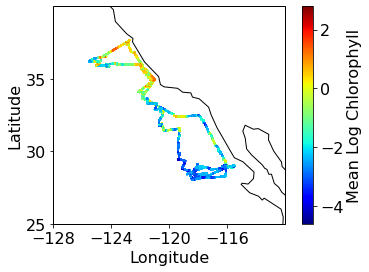

In [14]:
logchl = np.log(ds_usv_subset.CHLOR_MEAN)

font = {'size' : 16}
plt.rc('font', **font)
ax = plt.axes(projection=ccrs.PlateCarree())
cs1 = ax.scatter(ds_usv_subset.lon, ds_usv_subset.lat, s=3.0, c=logchl, edgecolor='none', cmap='jet')
ax.coastlines()
x1,x2,y1,y2 = -128,-112,25,40
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('Mean Log Chlorophyll')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

Collocate with Ocean Color Observations

Input 

In [15]:
## YYYY-MM-DD
start_date = np.datetime64(str_start_time[:10])
end_date   = np.datetime64(str_end_time[:10])

num_days = (end_date - start_date).tolist().days

# Track which days are kept
the_days = []

# variable to load
VAR = 'CHL'

# algorithm
ALG = 'chl_ocx'

# Binning period
BIN = '8D'  # DAY, 8D, MO, R32

# Spatial resolution
SRES = '9km'   # 4km, 9km



In [16]:
dap_urls = []

url_base = "https://oceandata.sci.gsfc.nasa.gov:443/opendap/MODISA/L3SMI/"


for ii in range(num_days):
    
    curr_date = start_date + ii
    
    curr_year = curr_date.tolist().year
    ref_date = np.datetime64('{0:d}-01-01'.format(curr_year))
    
    day_num = 1 + (curr_date - ref_date).tolist().days
    
    # We need to change the formatting a bit depending on the binning
    do = True
    if BIN == 'DAY':
        time_str = 'A{0:d}{1:03d}'.format(curr_year, day_num)
    elif BIN == '8D':
        if (int(day_num) - 1) % 8 == 0:
            targ_day = day_num + 7
            if targ_day > 365:
                targ_day = 365
            
            time_str = 'A{0:d}{1:03d}{2:d}{3:03d}'.format(curr_year, day_num, curr_year, targ_day)
        else:
            # There isn't an 8D set starting here
            do = False
    
    if do:
        file_url = url_base + \
                '{0:d}/{1:03d}/{2}'.format(curr_year, day_num, time_str) + \
                '.L3m_{0}_{1}_{2}_{3}'.format(BIN, VAR, ALG, SRES) + \
                '.nc'
    
        dap_urls += [file_url]
        
        the_days += [curr_date]
    
print('dap_urls containts {0:d} urls for {1} data.'.format(len(dap_urls), VAR))

dap_urls containts 7 urls for CHL data.


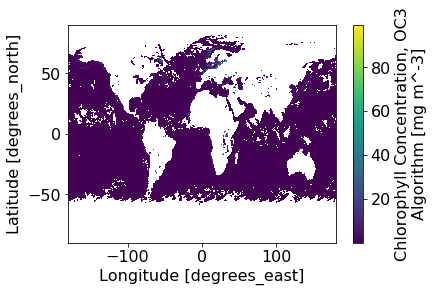

In [31]:
#test that the file you generate actually opens data by loading one time point
single_set = xr.open_dataset(dap_urls[0])

single_set.chl_ocx.plot(
    x="lon",
    y="lat",
);#plot the data to see what it looks like!

In [18]:
#dataset_id = 'PODAAC-GHGMR-4FJ04'  #MUR SST looked up on podaac website
dataset_id = 'PODAAC-GHK10-41N01'  #smaller data
gresult = p.granule_search(dataset_id=dataset_id,
                           start_time=start_time,
                           end_time=end_time,
                           items_per_page='100')
urls = putil.PodaacUtils.mine_opendap_urls_from_granule_search(gresult)
urls = [w[:-5] for w in urls]  #remove html from urls

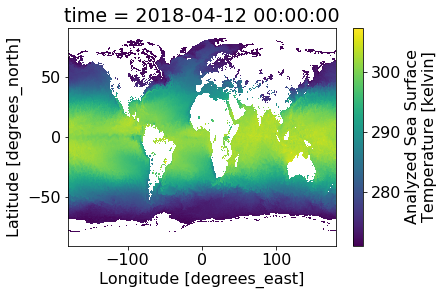

In [40]:
ds_sst = xr.open_mfdataset(urls,coords='minimal')
ds_sst

ds_sst.analysed_sst[0, ...].plot(
    x="lon",
    y="lat",
);

How big is all this data uncompressed? Will it fit into memory?
Use `.nbytes` / 1e9  to convert it into gigabytes

In [43]:
ds_sst.nbytes / 1e9  

4.0198541

## The NCEI trajectory format uses 'obs' as the coordinate.  This is an example of an 'older' style of data formatting that doesn't really mesh well with modern software capabilities. 

* So, let's change that by using [.swap_dims](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.swap_dims.html) to change the coordinate from `obs` to `time`
* Another thing, `latitude` and `longitude` are just long and annoying, lets [.rename](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.rename.html) them to `lat` and `lon`

* Finally, the first and last part of the cruise the USV is being towed, so let's only include data from `2018-04-12T02` to `2018-06-10T18`


# Xarray interpolation won't run on chunked dimensions.  
1. First let's subset the data to make it smaller to deal with by using the cruise lat/lons
    * Find the max/min of the lat/lon using `.lon.min().data`

1. Now load the data into memory (de-Dask-ify) it using `.load()`  


In [48]:
#Step 1 from above
print('min max lat lon:', ds_usv_subset.lon.min().data,ds_usv_subset.lon.max().data,ds_usv_subset.lat.min().data,ds_usv_subset.lat.max().data)
lon_min,lon_max = ds_usv_subset.lon.min().data,ds_usv_subset.lon.max().data
lat_min,lat_max = ds_usv_subset.lat.min().data,ds_usv_subset.lat.max().data
subset_sst = ds_sst.sel(lon=slice(lon_min,lon_max),
                  lat=slice(lat_max,lat_min))

subset_sst

min max lat lon: -125.55297279999999 -115.5226624 28.0176832 37.6797408


<xarray.Dataset>
Dimensions:         (lat: 96, lon: 100, time: 62)
Coordinates:
  * lat             (lat) float32 37.600002 37.5 37.4 ... 28.300001 28.2 28.1
  * lon             (lon) float32 -125.5 -125.4 -125.3 ... -115.700005 -115.6
  * time            (time) object 2018-04-12 00:00:00 ... 2018-06-12 00:00:00
Data variables:
    analysed_sst    (time, lat, lon) float32 dask.array<shape=(62, 96, 100), chunksize=(1, 96, 100)>
    analysis_error  (time, lat, lon) float32 dask.array<shape=(62, 96, 100), chunksize=(1, 96, 100)>
    mask            (time, lat, lon) int16 dask.array<shape=(62, 96, 100), chunksize=(1, 96, 100)>
Attributes:
    Conventions:            NAVO_netcdf_v3.4
    title:                  NAVOCEANO 10km Analyzed Sea Surface Temperature
    DSD_entry_id:           NAVO-L4HR1m-GLOB-K10_SST
    reference:              https://oceanography.navy.mil/legacy/web
    institution:            Naval Oceanographic Office
    contact:                doug.may@navy.mil
    GDS_versi

Text(0, 0.5, 'Latitude')

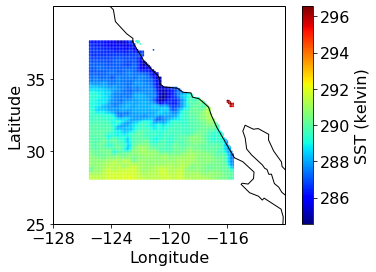

In [62]:
xv, yv = np.meshgrid(subset_sst.lon, subset_sst.lat)
font = {'size' : 16}
plt.rc('font', **font)
ax = plt.axes(projection=ccrs.PlateCarree())
cs1 = ax.scatter(xv, yv, s=3.0, c=subset_sst.analysed_sst[0,:,:], edgecolor='none', cmap='jet')
ax.coastlines()
x1,x2,y1,y2 = -128,-112,25,40
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('SST (kelvin)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')





In [63]:

def preprocess_set(dset, time):
    return dset.sel(lon=slice(lon_min,lon_max),lat=slice(lat_max,lat_min))

data_sets = [preprocess_set(xr.open_dataset(url), ind) \
             for (url,ind) \
             in zip(dap_urls, np.arange(num_days))]

time_array = xr.DataArray(the_days, None, 'time', 'time')

subset_chl = xr.concat(data_sets, time_array)


#Step 2 from above
subset_sst.load()
subset_chl.load()

<xarray.Dataset>
Dimensions:  (eightbitcolor: 256, lat: 116, lon: 121, rgb: 3, time: 7)
Coordinates:
  * lat      (lat) float32 37.624996 37.541664 37.458332 ... 28.124998 28.041666
  * lon      (lon) float32 -125.541664 -125.458336 ... -115.625 -115.541664
  * time     (time) datetime64[ns] 2018-04-15 2018-04-23 ... 2018-06-02
Dimensions without coordinates: eightbitcolor, rgb
Data variables:
    palette  (time, rgb, eightbitcolor) int8 -109 0 108 -112 0 111 ... 0 0 0 0 0
    chl_ocx  (time, lat, lon) float32 0.33946106 0.40241784 ... 1.282373
Attributes:
    _NCProperties:                     version=1|netcdflibversion=4.4.1.1|hdf...
    product_name:                      A20181052018112.L3m_8D_CHL_chl_ocx_9km.nc
    instrument:                        MODIS
    title:                             MODISA Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          Aqua
    temporal_range:          

Text(0, 0.5, 'Latitude')

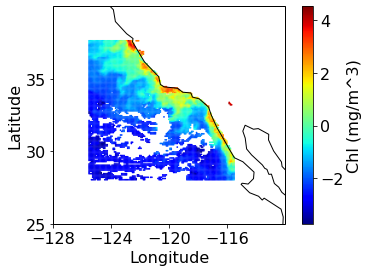

In [64]:
xv2, yv2 = np.meshgrid(subset_chl.lon, subset_chl.lat)

font = {'size' : 16}
plt.rc('font', **font)
ax = plt.axes(projection=ccrs.PlateCarree())
cs1 = ax.scatter(xv2, yv2, s=3.0, c=(np.log(subset_chl.chl_ocx[0,:,:])), edgecolor='none', cmap='jet')
ax.coastlines()
x1,x2,y1,y2 = -128,-112,25,40
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('Chl (mg/m^3)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Collocate USV data with MUR data and Ocean Color Data
There are different options when you interpolate.  First, let's just do a linear interpolation using [.interp()](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.interp.html#xarray.Dataset.interp)

`Dataset.interp(coords=None, method='linear', assume_sorted=False, kwargs={}, **coords_kwargs))`



In [65]:
#make sure they both have the same time stamp format otherwise the interpolation will fail
subset_sst['time'] = subset_sst.indexes['time'].to_datetimeindex()
subset_sst.time


<xarray.DataArray 'time' (time: 62)>
array(['2018-04-12T00:00:00.000000000', '2018-04-13T00:00:00.000000000',
       '2018-04-14T00:00:00.000000000', '2018-04-15T00:00:00.000000000',
       '2018-04-16T00:00:00.000000000', '2018-04-17T00:00:00.000000000',
       '2018-04-18T00:00:00.000000000', '2018-04-19T00:00:00.000000000',
       '2018-04-20T00:00:00.000000000', '2018-04-21T00:00:00.000000000',
       '2018-04-22T00:00:00.000000000', '2018-04-23T00:00:00.000000000',
       '2018-04-24T00:00:00.000000000', '2018-04-25T00:00:00.000000000',
       '2018-04-26T00:00:00.000000000', '2018-04-27T00:00:00.000000000',
       '2018-04-28T00:00:00.000000000', '2018-04-29T00:00:00.000000000',
       '2018-04-30T00:00:00.000000000', '2018-05-01T00:00:00.000000000',
       '2018-05-02T00:00:00.000000000', '2018-05-03T00:00:00.000000000',
       '2018-05-04T00:00:00.000000000', '2018-05-05T00:00:00.000000000',
       '2018-05-06T00:00:00.000000000', '2018-05-07T00:00:00.000000000',
       '2018-0

In [66]:
#ts.index = pd.to_datetime([DT.datetime.fromtimestamp(time.mktime(item))for item in ds_usv_subset.index])
ds_collocated_mur = subset_sst.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='linear')
ds_collocated_oc = subset_chl.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='linear')

In [67]:
ds_collocated_mur

<xarray.Dataset>
Dimensions:         (time: 85980)
Coordinates:
    lat             (time) float64 37.51 37.51 37.51 37.51 ... 37.68 37.68 37.68
    lon             (time) float64 -122.8 -122.8 -122.8 ... -122.7 -122.7 -122.7
  * time            (time) datetime64[ns] 2018-04-12T02:00:00 ... 2018-06-10T18:59:00
    trajectory      float32 1002.0
Data variables:
    analysed_sst    (time) float64 286.3 286.3 286.3 286.3 ... nan nan nan nan
    analysis_error  (time) float64 0.43 0.43 0.4301 0.4301 ... nan nan nan nan
    mask            (time) float64 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan nan
Attributes:
    Conventions:            NAVO_netcdf_v3.4
    title:                  NAVOCEANO 10km Analyzed Sea Surface Temperature
    DSD_entry_id:           NAVO-L4HR1m-GLOB-K10_SST
    reference:              https://oceanography.navy.mil/legacy/web
    institution:            Naval Oceanographic Office
    contact:                doug.may@navy.mil
    GDS_version_id:         v1.0-rev1.7
    

# Collocate USV data with MUR data
There are different options when you interpolate.  First, let's just do a nearest point rather than interpolate the data
`method = 'nearest'`

In [16]:
ds_collocated_nearest_mur = subset_sst.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='nearest')
ds_collocated_nearest_oc = subset_chl.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='nearest')

## Now, calculate the different in SSTs and print the [.mean()](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.mean.html#xarray.DataArray.mean) and [.std()](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.std.html#xarray.DataArray.std)
For the satellite data we need to use `sst` and for the USV data we need to use `TEMP_CTD_MEAN`

In [35]:
ds_collocated_nearest_mur.analysed_sst


<xarray.DataArray 'analysed_sst' (time: 85980)>
array([286.35, 286.35, 286.35, ...,    nan,    nan,    nan], dtype=float32)
Coordinates:
    lat         (time) float64 37.51 37.51 37.51 37.51 ... 37.68 37.68 37.68
    lon         (time) float64 -122.8 -122.8 -122.8 ... -122.7 -122.7 -122.7
  * time        (time) datetime64[ns] 2018-04-12T02:00:00 ... 2018-06-10T18:59:00
    trajectory  float32 1002.0
Attributes:
    long_name:      Analyzed Sea Surface Temperature
    standard_name:  sea_surface_temperature
    type:           depth 1m
    units:          kelvin
    valid_min:      -20
    valid_max:      350

In [36]:
ds_usv_subset.TEMP_CTD_MEAN

<xarray.DataArray 'TEMP_CTD_MEAN' (time: 85980)>
array([13.54 , 13.558, 13.573, ..., 10.581, 10.548, 10.541])
Coordinates:
    trajectory  float32 1002.0
  * time        (time) datetime64[ns] 2018-04-12T02:00:00 ... 2018-06-10T18:59:00
    lat         (time) float64 37.51 37.51 37.51 37.51 ... 37.68 37.68 37.68
    lon         (time) float64 -122.8 -122.8 -122.8 ... -122.7 -122.7 -122.7
Attributes:
    standard_name:              sea_water_temperature
    long_name:                  Seawater temperature
    units:                      degrees_c
    last_calibrated:            2017-12-14
    update_period:              Attribute edlided: Unsupported attribute type...
    model_product_page:         http://rdinstruments.com/product/ctd/citadel-...
    device_name:                Teledyne CTD (2632)
    installed_date:             2017-10-02T18:48:43Z
    nominal_sampling_schedule:  12s on, 48s off, centered at :00
    installed_height:           -0.6
    serial_number:              2632


In [38]:
dif_mur = ds_collocated_nearest_mur.analysed_sst-(ds_usv_subset.TEMP_CTD_MEAN + 273.15)
print('mean difference = ',dif_mur.mean().data)
print('STD = ',dif_mur.std().data)

dif_oc = ds_collocated_nearest_oc.chl_ocx-ds_usv_subset.CHLOR_MEAN
print('mean difference = ',dif_oc.mean().data)
print('STD = ',dif_oc.std().data)

mean difference =  0.20544484005976774
STD =  0.48167126451293674
mean difference =  0.004300322455089829
STD =  0.4741116726838073


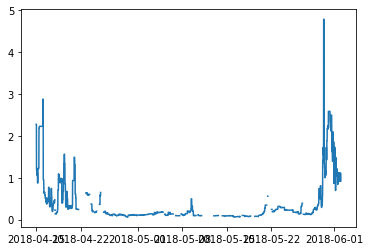

In [53]:
plt.plot(ds_collocated_nearest_oc.time,ds_collocated_nearest_oc.chl_ocx)